In [17]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from lippmann_exemplars import LippmanExemplars
from hopfield_network import HopfieldNetwork


Lets now initialize the network using these exemplars, completing a few checks to confirm the structure of the weights matrix is consistent with our expectations:
- Is the matrix the correct size?  It should be 120 x 120 as each exemplar is 12x10, flattened to a 120 element vector.
- Is the diagonal 0?  That is, does $w_{ij} = 0$ when $i = j$?
- Is it symmetric?  That is, does $w_{ij} = w_{ji}$ when $i \neq j$?

In [2]:
#network = HopfieldNetwork(exemplars)

#assert(len(network.weight_matrix) == 120)
#assert(len(network.weight_matrix[0]) == 120)

# Check that the diagonal is 0
#for i in range(0, 100):
#    assert(network.weight_matrix[i][i] == 0)
    
# Symmetric
#assert(np.allclose(network.weight_matrix, network.weight_matrix.T) == True)
#print network.weight_matrix

Writeup regarding Hopfield networks, Hebbian & Storkey learning rules.

----

**Experiment 1: Successful digit exemplar retrieval from Hopfield networks**

The usefulness of trained Hopfield Network hinges largely on the ability of the network to recall one of the exemplars $p$ on which it was trained when supplied a noisy variant $p^{\prime}$. This recollection of an exemplar happens by first imposing the noisy varient $p^{\prime}$ on the network to obtain an initial output, then (re)imposing that output and each subsequent output iteratively on the network until output no longer changes, having converged to a fixed point in the system - the expected exemplar $p$.

Imposing the noisy input patterns on the network to recall an exemplar can occur synchronously or asynchronously. The former requires that for a timestep $t$ in the iteration,  each neuron in the network is activated simultaneously using the output produced from iteration $t-1$, typically accomplished through a simple matrix multiplication operation: ###TODO: Add details
//OLD content
applying the formula $x_{k+1} = F_{h}(\textbf{W}x_{k})$ iteratively through $k=[0, n]$, where:
- $x_k = p^{\prime}$ when $k = 0$
- $n$ is chosen somewhat arbitrarily, but generally large enough to ensure $x_{k=n}$ represents the exemplar $p$ we aim to retrieve _OR_ the network is stuck in a cycle, thus incapable of retrieving the exemplar at all.
- $F_{h}$ is the hard limiting function, defined as 
- $\textbf{W}$ is the weights matrix of the Hopfield Network


Unfortunately, the synchronous approach is not without limitations. It provides no strong gaurantee of converging to a single output and may instead cycle through multiple output patterns repeatedly. It would be preferable then to use a modality that does create convergence so that we can readily identify a _final_ output of the network from which we can evaluate if it successfully recovered the exemplar we expected.  Asynchronous updating has been proven to result in this converage (citation - Lippmann). It executes as follows:
## TODO: Describe asynchronous execution


With our methodology for recalling exemplars established lets move on to our experiment. Here we will evaluate the ability to recover exemplars from a Hopfield network trained under the Hebbian & Storkey learning rules. The exemplars we have chosen are from the Lippmann paper (citation) as they were created by hand with the intent to exemplify the a Hopfield Network's ability to recall exemplars.  The exemplars consist of 8 patterns covering the digits 0, 1, 2, 3, 4, 6 and 9, with an additional pattern being a simple block. By observation, you can see that some patterns have significant overlap - such as the rightmost strokes for 2, 3 & 4 - while other patterns are distinctly seperate - such as the block & 1:



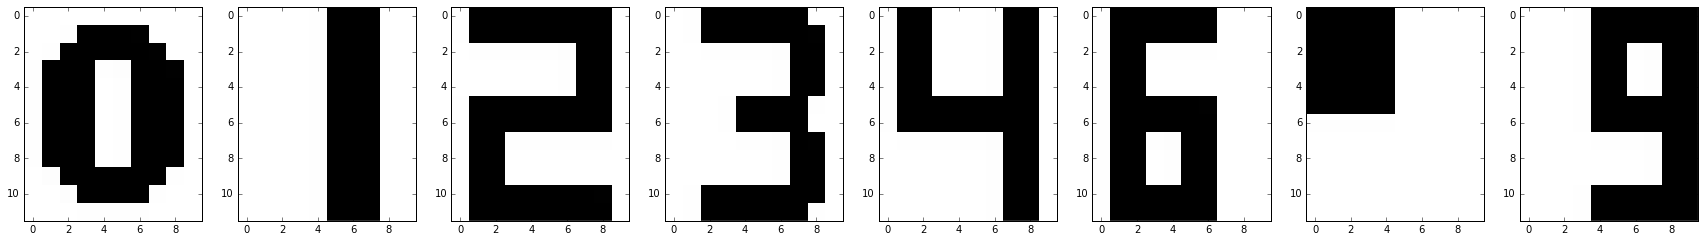

In [3]:
exemplars = LippmanExemplars.get_exemplars()

figure, axes = plt.subplots(1, len(exemplars), figsize=(30,30))
for i in range(0, len(exemplars)):
    axes[i].imshow(LippmanExemplars.to_matrix(exemplars[i]), cmap='Greys', interpolation='None')

With our exemplars chosen, our experiment will look at what happens when we train a Hopfield Network under the Hebbian Learning rule, then attempt to recall each exemplar when imposing on the network a noisy varient.  We'll continue to replicate Lippmann's example by using the same methodology to generate the noisy exemplar - randomly switching the elements of the exemplar with a probability of _P(switch) = .25_. 

Lets start with a single iteration of recall attempts for all the exemplars.

Number of neurons:120
Capacity: 12.5326586914


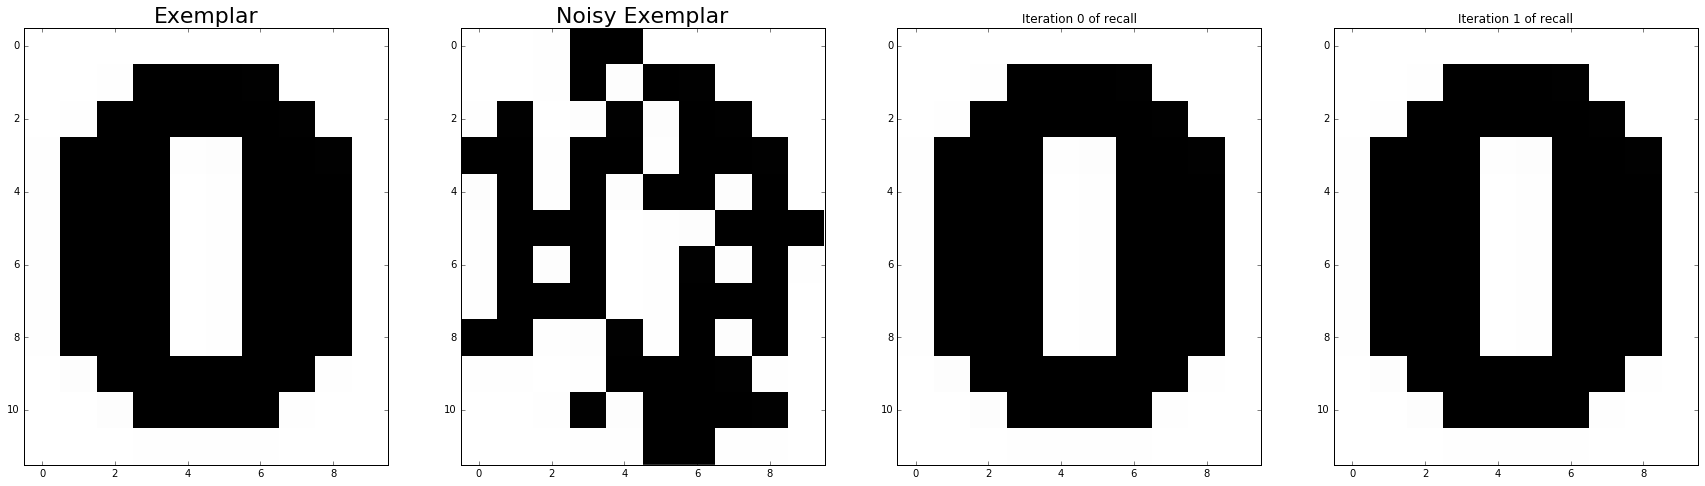

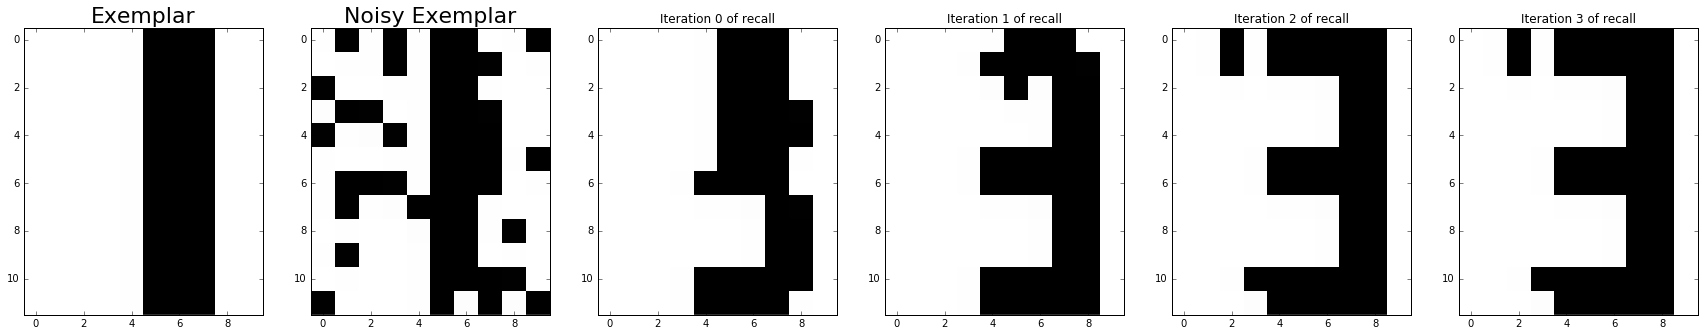

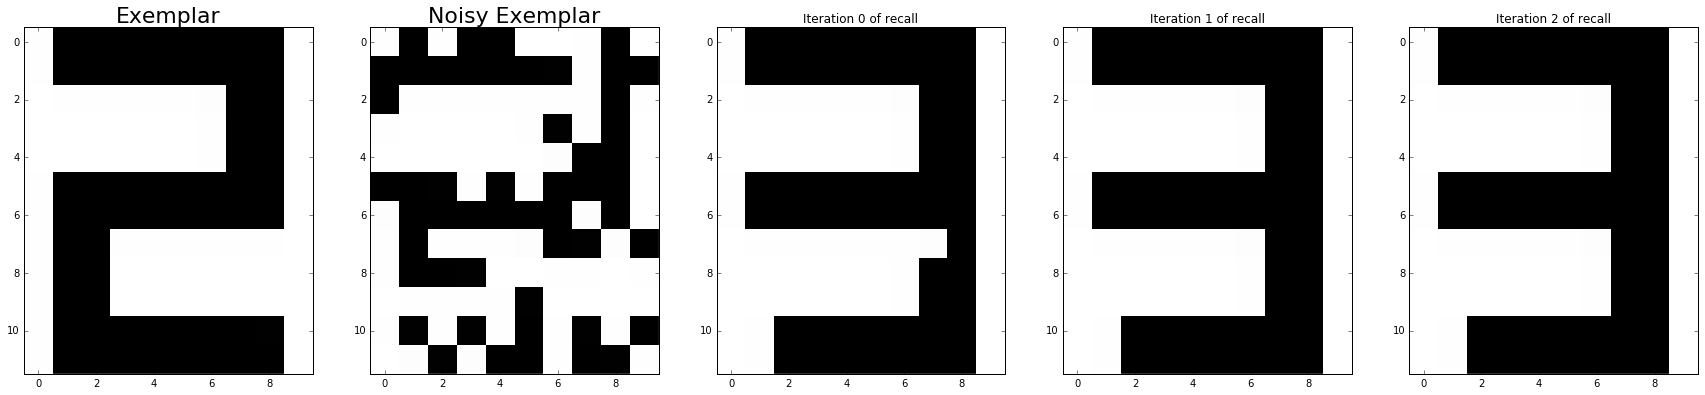

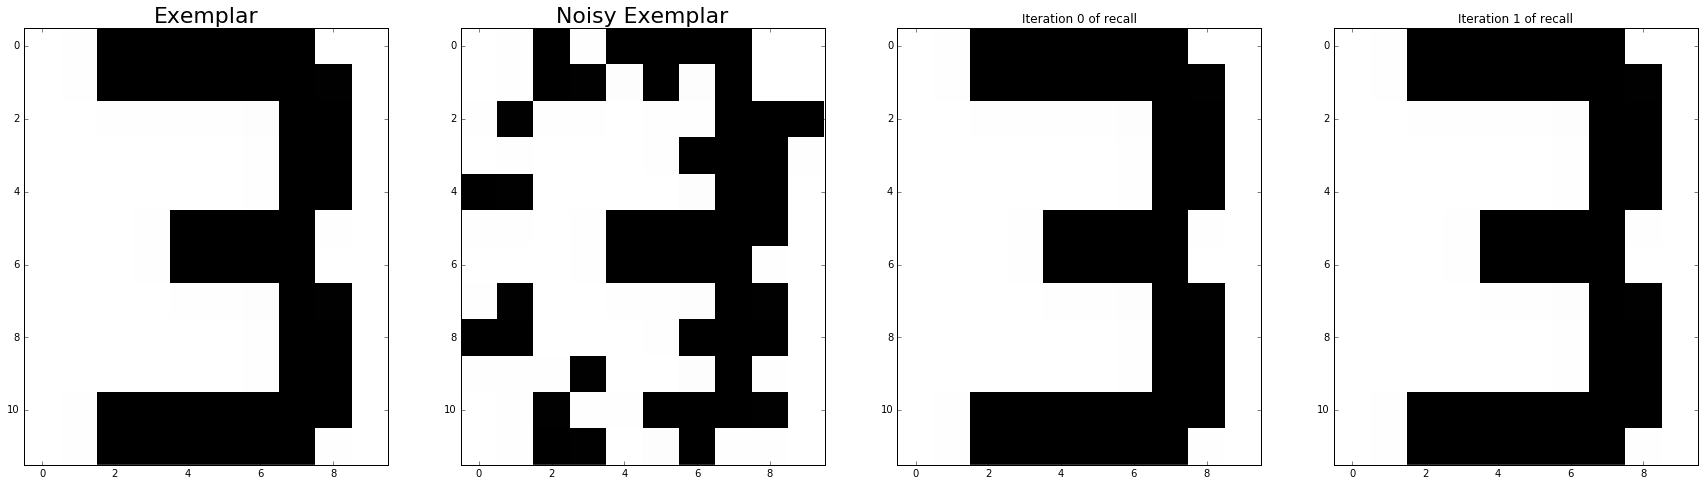

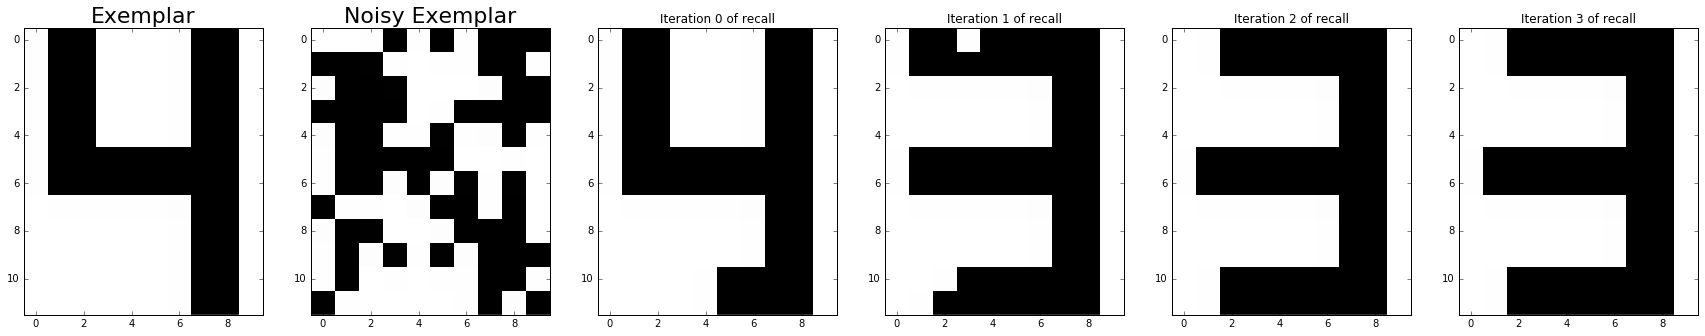

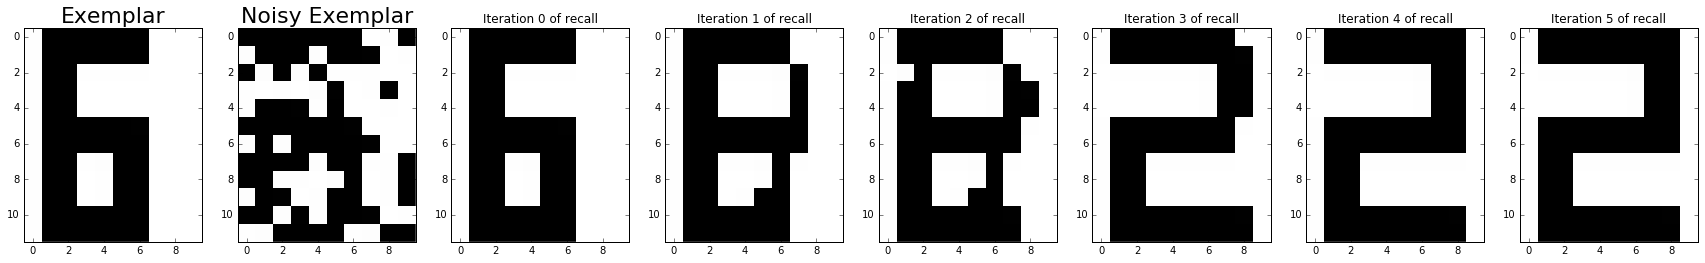

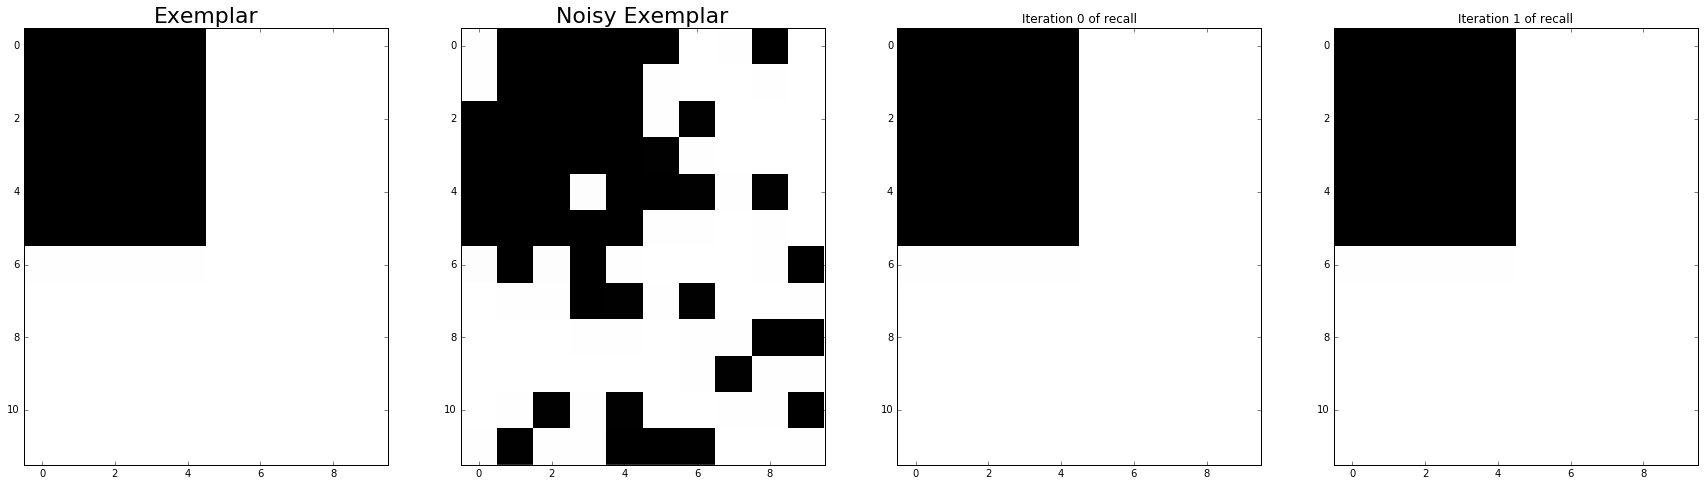

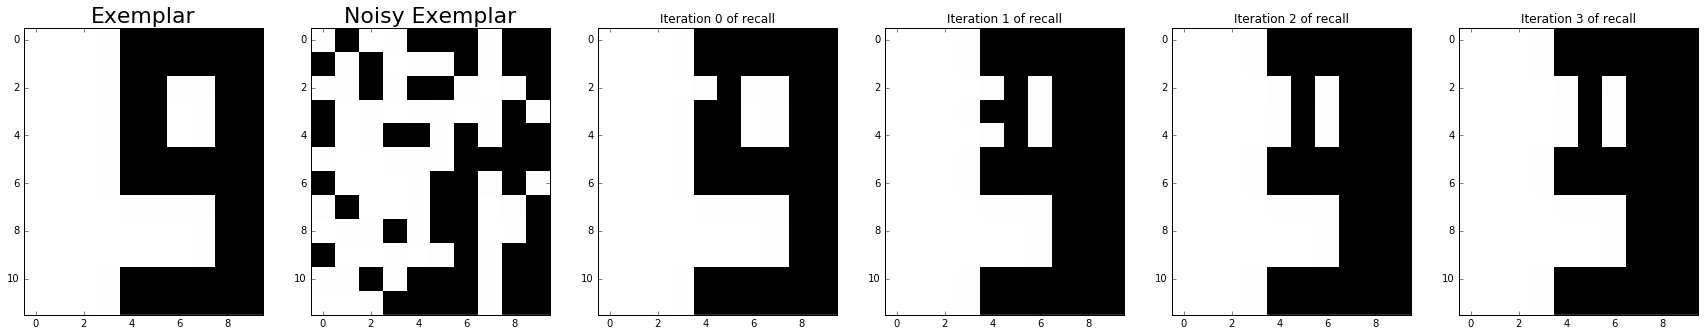

In [4]:
random.seed(123123)
exemplars = LippmanExemplars.get_exemplars()[0:8]
network = HopfieldNetwork(exemplars, learning_rule="Hebb")

print "Number of neurons:{0}".format(network.num_neurons)
print "Capacity: {0}".format(network.capacity)

for exemplar in exemplars:
    noisy_exemplar = LippmanExemplars.add_noise(exemplar, p=.25)
    results = network.asynchronous_recall(noisy_exemplar)

    # output results of recall
    figure, axes = plt.subplots(1, len(results) + 2, figsize=(30,30))
    
    # Original version
    axes[0].imshow(LippmanExemplars.to_matrix(exemplar), cmap='Greys', interpolation='None')
    axes[0].set_title("Exemplar", fontdict={'fontsize':22})
    axes[0]
    
    # Noisy version
    axes[1].imshow(LippmanExemplars.to_matrix(noisy_exemplar), cmap='Greys', interpolation='None')
    axes[1].set_title("Noisy Exemplar", fontdict={'fontsize':22})
    
    for i, result in enumerate(results):
        axes[i+2].imshow(LippmanExemplars.to_matrix(result), cmap='Greys', interpolation='None')
        axes[i+2].set_title("Iteration {0} of recall".format(i, fontdict={'fontsize':22}))

As we can see from the results, the exemplars for 0, 3 and square block are successfully recovered.  However, the exemplars for 1, 2 and 4 return corrupted versions of the exemplar 3 because of considerable overlap in the digits.  The exemplar for 6 gravitates to 2.  The exemplar returned for 9 is clearly close, but not the original 9.

The successful recovery of the training exemplar is in part dependent on the noise introduced in the noisy varient and the degree to which that noise might have shifted the noisy exemplar towards one of the other exemplars in the training set. We can therefore minimize the impact of variation in the noise by repeatedly running the experiment as a series of trials where the network is trained, a noisy varient of each exemplar generated and imposed on it, and the recalled exemplar evaluated to determine if it is the expected exemplar or not.  We'll run this trial 100 times and calculate and _error rate_ for the recovery of each exemplar:

In [13]:
random.seed(123123)
exemplars = LippmanExemplars.get_exemplars()[0:8]
network = HopfieldNetwork(exemplars, learning_rule="Hebb")


error_rates = []
for i, exemplar in enumerate(exemplars):
    print "Testing on exemplar {0}".format(i)
    errors = 0
    for i in range(0, 100):
        noisy_exemplar = LippmanExemplars.add_noise(exemplar, p=.25)
        p = network.asynchronous_recall(noisy_exemplar)[-1]
        if p != exemplar:
            errors += 1
    error_rates.append(1.0 * errors / 100)

for i, rate in enumerate(error_rates):
    print "Error rate for exemplar: {0} was {1}%.".format(i, rate * 100)
    
m = (1.0 * sum(error_rates)) / len(error_rates)
print "Mean error rate: {0}%".format(m * 100)

Testing on exemplar 0
Testing on exemplar 1
Testing on exemplar 2
Testing on exemplar 3
Testing on exemplar 4
Testing on exemplar 5
Testing on exemplar 6
Testing on exemplar 7
Error rate for exemplar: 0 was 27.0%.
Error rate for exemplar: 1 was 100.0%.
Error rate for exemplar: 2 was 46.0%.
Error rate for exemplar: 3 was 52.0%.
Error rate for exemplar: 4 was 100.0%.
Error rate for exemplar: 5 was 100.0%.
Error rate for exemplar: 6 was 50.0%.
Error rate for exemplar: 7 was 100.0%.
Mean error rate: 71.875%


Now we'll repeat the experiment after training the Network using the Storkey Learning rule. 

Number of neurons:120
Capacity: TO BE DETERMINED


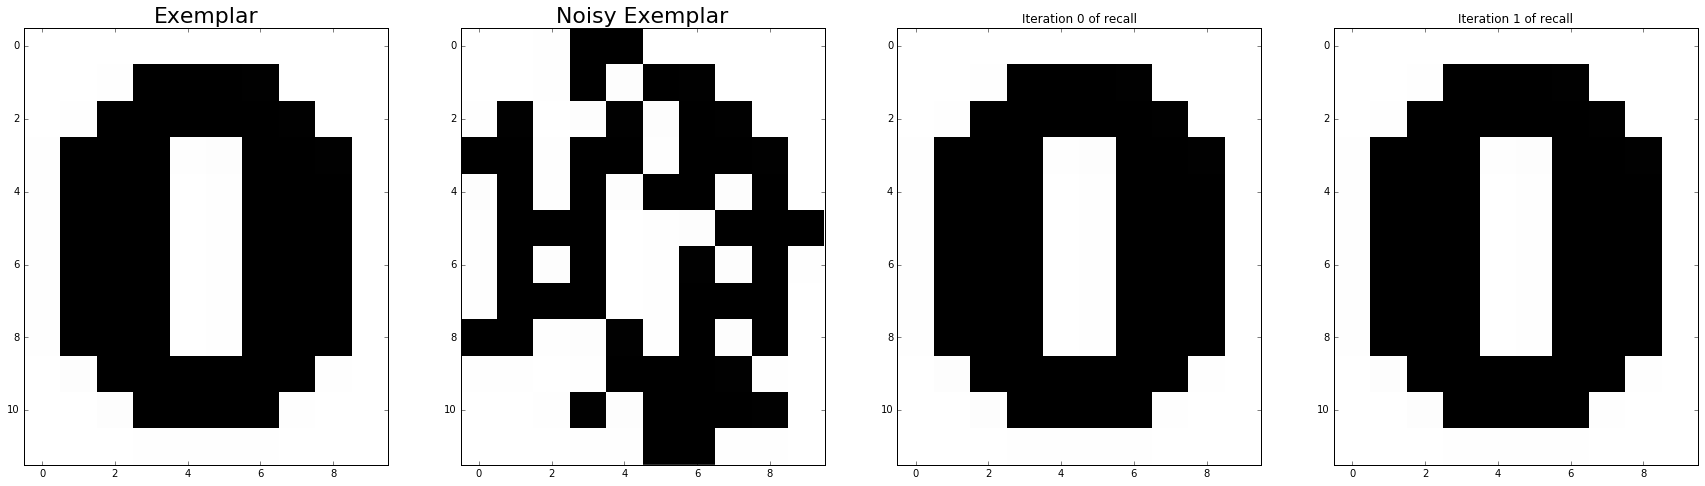

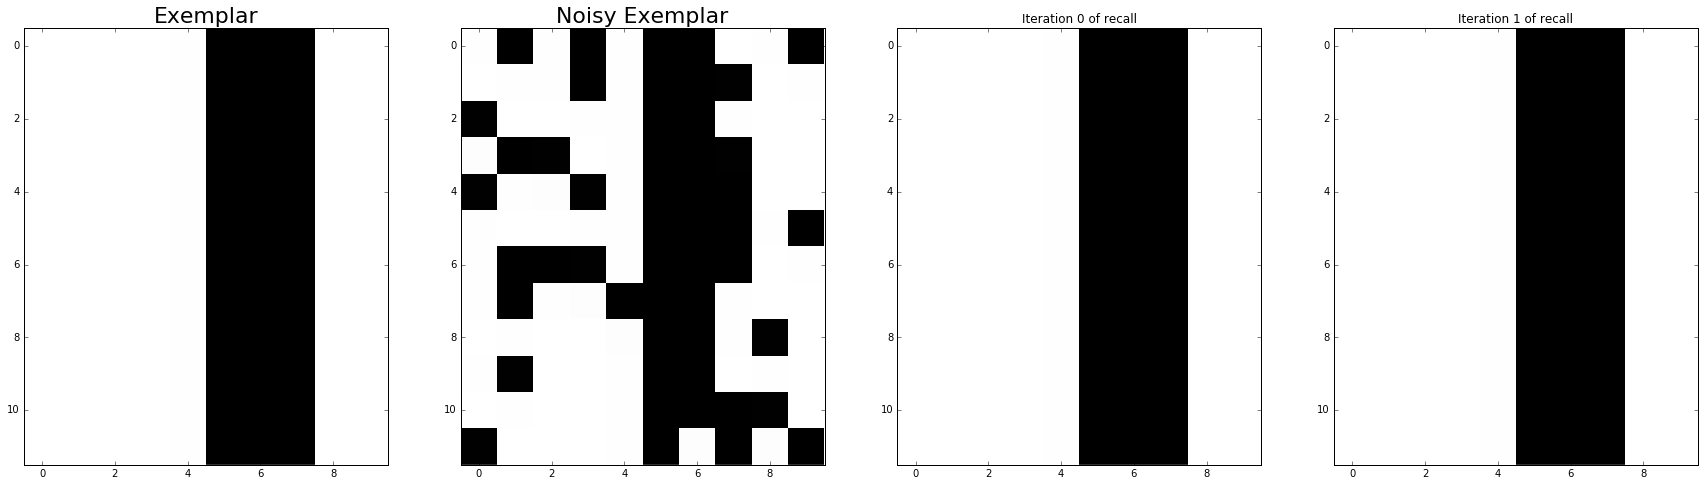

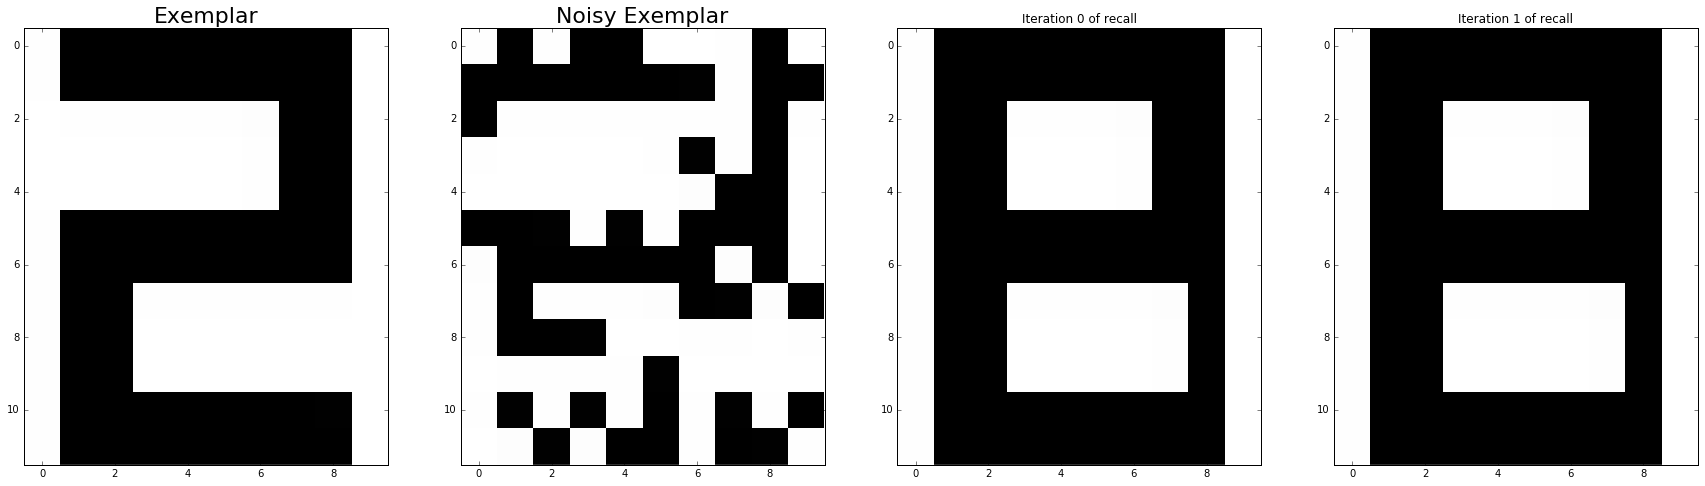

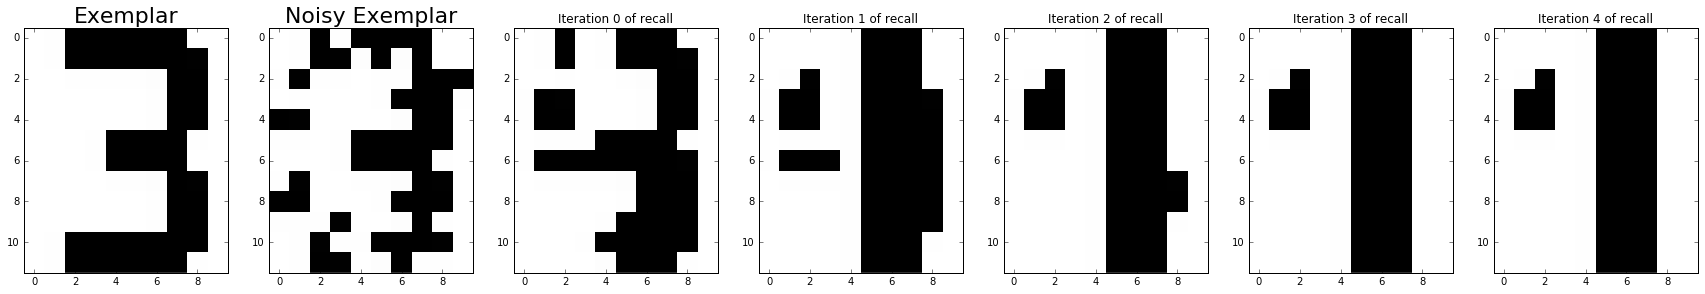

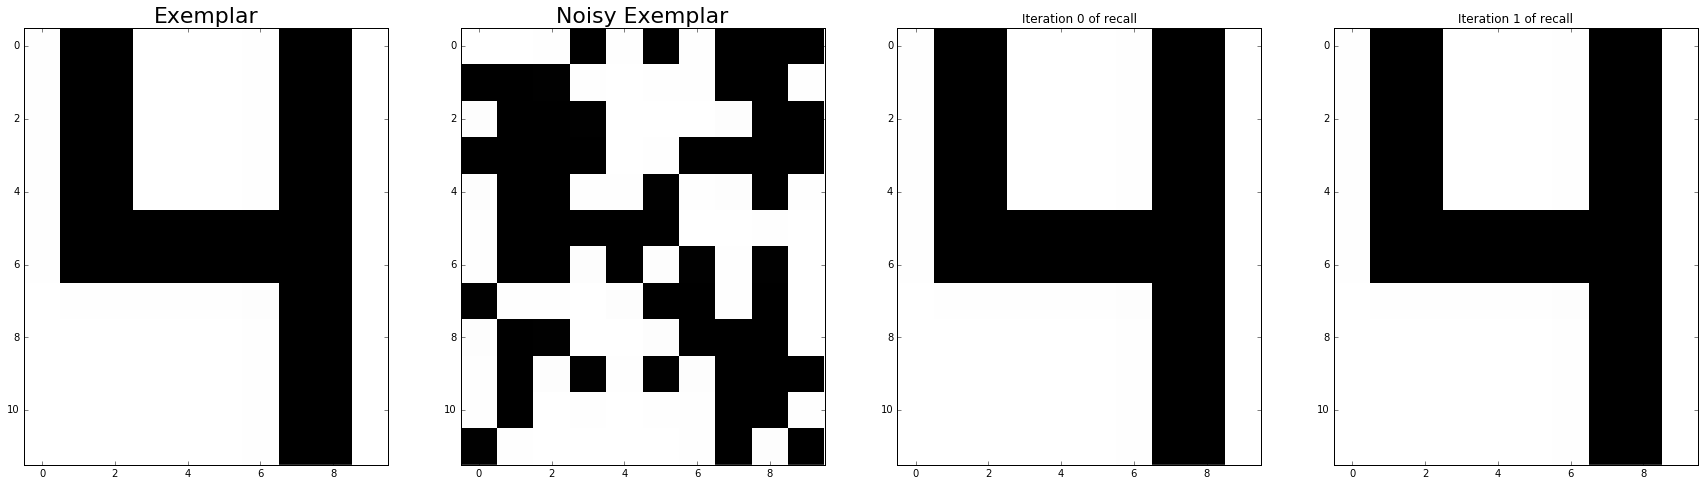

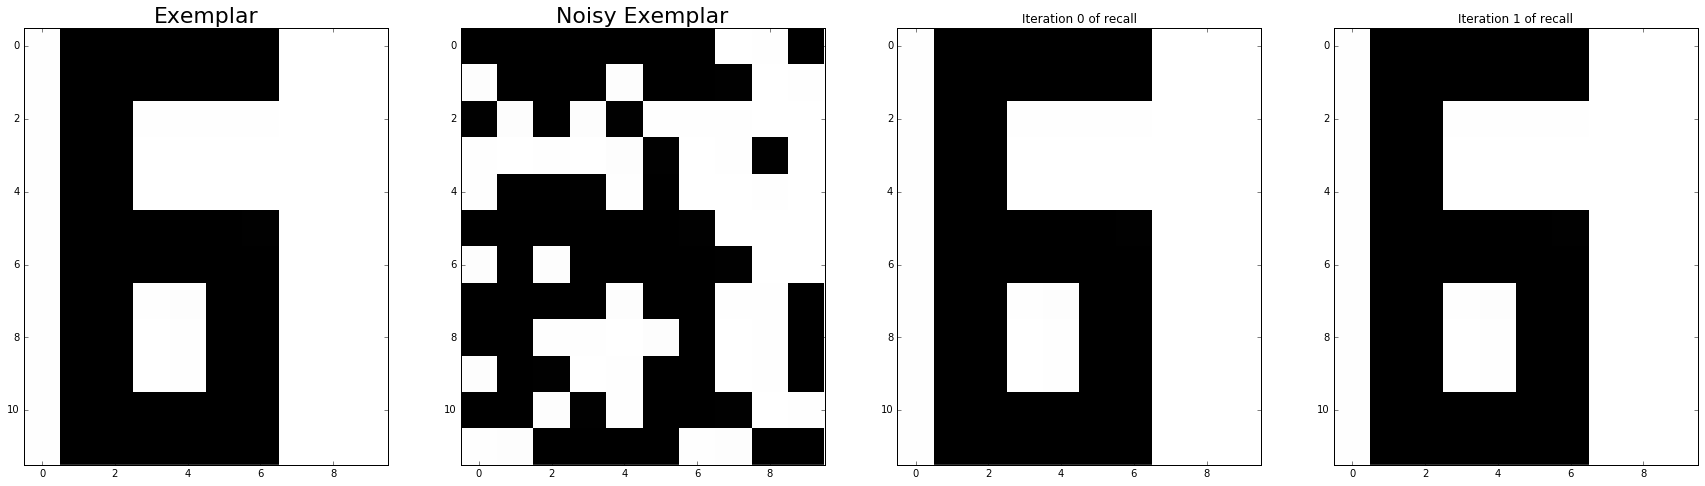

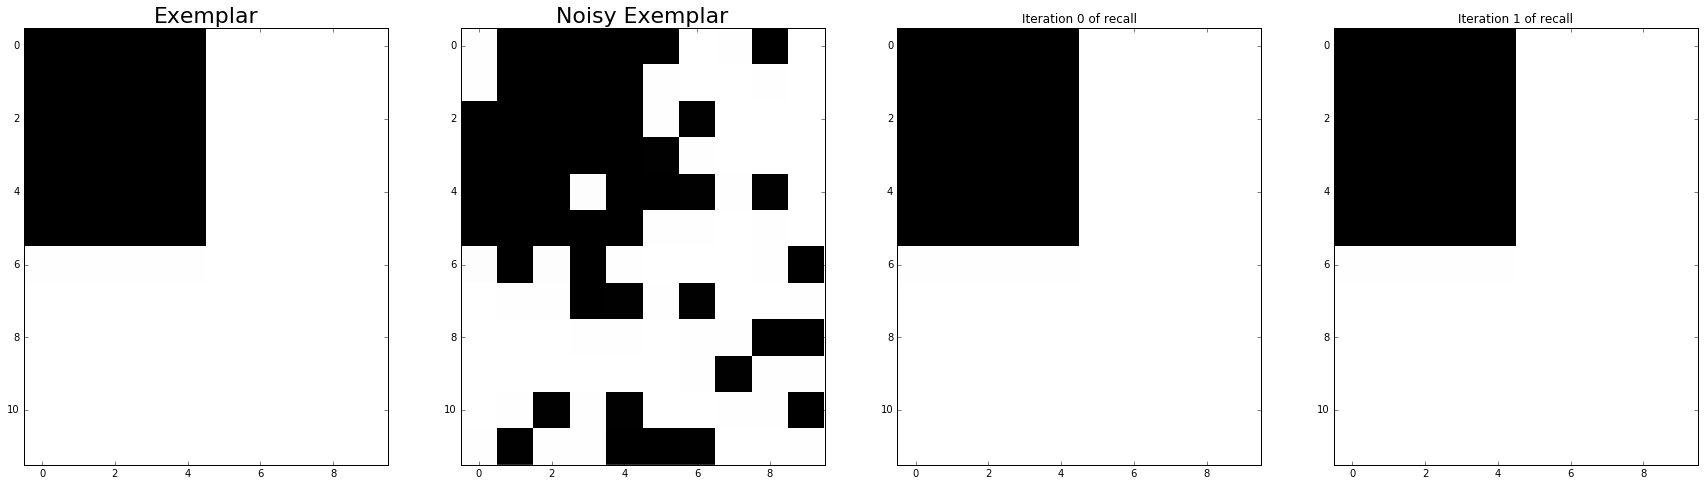

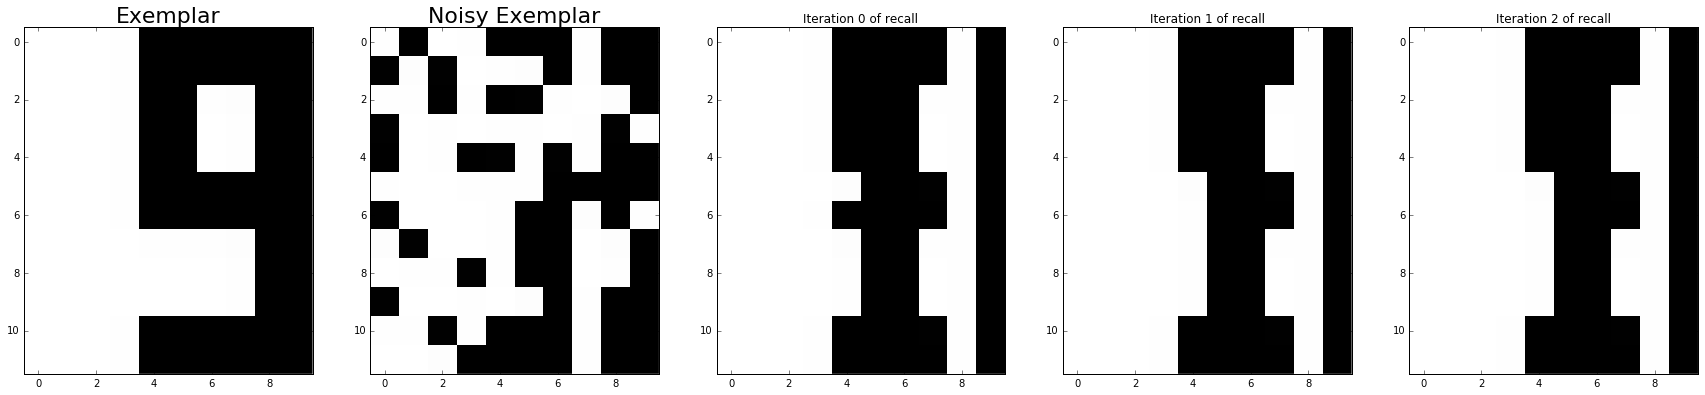

In [15]:
random.seed(123123)
exemplars = LippmanExemplars.get_exemplars()[0:8]
network = HopfieldNetwork(exemplars, learning_rule="Storkey")

print "Number of neurons:{0}".format(network.num_neurons)
print "Capacity: {0}".format("TO BE DETERMINED")

for exemplar in exemplars:
    noisy_exemplar = LippmanExemplars.add_noise(exemplar, p=.25)
    results = network.asynchronous_recall(noisy_exemplar)

    # output results of recall
    figure, axes = plt.subplots(1, len(results) + 2, figsize=(30,30))
    
    # Original version
    axes[0].imshow(LippmanExemplars.to_matrix(exemplar), cmap='Greys', interpolation='None')
    axes[0].set_title("Exemplar", fontdict={'fontsize':22})
    axes[0]
    
    # Noisy version
    axes[1].imshow(LippmanExemplars.to_matrix(noisy_exemplar), cmap='Greys', interpolation='None')
    axes[1].set_title("Noisy Exemplar", fontdict={'fontsize':22})
    
    for i, result in enumerate(results):
        axes[i+2].imshow(LippmanExemplars.to_matrix(result), cmap='Greys', interpolation='None')
        axes[i+2].set_title("Iteration {0} of recall".format(i, fontdict={'fontsize':22}))

A number of our exemplars have improved recall.  We can see 0, 1, 4, 6, and the block exemplar are recovered successfully from the noisy varient. 

Lets followup by repeating our trials determine the error rates for each exemplar:

In [16]:
random.seed(123123)
exemplars = LippmanExemplars.get_exemplars()[0:8]
network = HopfieldNetwork(exemplars, learning_rule="Storkey")

error_rates = []
for i, exemplar in enumerate(exemplars):
    print "Testing on exemplar {0}".format(i)
    errors = 0
    for i in range(0, 100):
        noisy_exemplar = LippmanExemplars.add_noise(exemplar, p=.25)
        p = network.asynchronous_recall(noisy_exemplar)[-1]
        if p != exemplar:
            errors += 1
    error_rates.append(1.0 * errors / 100)

for i, rate in enumerate(error_rates):
    print "Error rate for exemplar: {0} was {1}%.".format(i, rate * 100)
    
m = (1.0 * sum(error_rates)) / len(error_rates)
print "Mean error rate: {0}%".format(m * 100)

Testing on exemplar 0
Testing on exemplar 1
Testing on exemplar 2
Testing on exemplar 3
Testing on exemplar 4
Testing on exemplar 5
Testing on exemplar 6
Testing on exemplar 7
Error rate for exemplar: 0 was 1.0%.
Error rate for exemplar: 1 was 10.0%.
Error rate for exemplar: 2 was 100.0%.
Error rate for exemplar: 3 was 95.0%.
Error rate for exemplar: 4 was 3.0%.
Error rate for exemplar: 5 was 2.0%.
Error rate for exemplar: 6 was 0.0%.
Error rate for exemplar: 7 was 6.0%.
Mean error rate: 27.125%


We've achieved a significant reduction in the mean error rate.  

###TODO:  Insert a side by side graph of the error rates per exemplar and discuss further.

----
**Experiment 2:  Saturating a Hopfield Network**

The motivation for Storkey's new learning rule was to determine if the capacity limitations of a Hopfield Network could be improved upon while still retaining the desired learning rule characteristics of locality, incrementality and immediacy.  A Network trained via Hebbian learning will have the absolute capacity of $\frac{n}{(2 \ln{n})}$.  The Storkey Learning Rule can be show analytically to have the absolute capacity $\frac{n}{(\sqrt{2 \ln{n}})}, which is a significant improvement.  Here we will exercise that by generating Hopfield Networks of increasing size (# of neurons) :

n = 5
- Hebbian
- Storkey


In [23]:
for i in range(5, 10):
    hebbian = (1.0 * i) / (2 * math.log(i))
    storkey = (1.0 * i) / math.sqrt(2 * math.log(i))
    print "For {0} nodes:  Hebb capactiy: {1},  Storkey capacity: {2}".format(i, hebbian, storkey)
    
    p = i * .13
    print "P is {0}".format(p)

For 5 nodes:  Hebb capactiy: 1.5533373364,  Storkey capacity: 2.78687758647
P is 0.65
For 6 nodes:  Hebb capactiy: 1.67433187965,  Storkey capacity: 3.16954117782
P is 0.78
For 7 nodes:  Hebb capactiy: 1.79864419829,  Storkey capacity: 3.54831077952
P is 0.91
For 8 nodes:  Hebb capactiy: 1.92359338785,  Storkey capacity: 3.9228493602
P is 1.04
For 9 nodes:  Hebb capactiy: 2.04803825991,  Storkey capacity: 4.293290619
P is 1.17


####TODO:  insert description of the Storkey rule

Now we'll train a new instance of a Hopfield Network using the _Storkey_ learning rule, with the same set of exemplars.